In [1]:
#Loading the libraries and compiling the c++ module

from torch.utils.cpp_extension import load
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import math
import lightning
import torchvision
from torch.utils.tensorboard import SummaryWriter
import pytorch_model_summary as pms


colab = False
if colab:
  import os
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir("/content/drive/MyDrive/Colab Notebooks/Work/annpid")
  %load_ext tensorboard
  %pip install Ninja
  %pip install ipympl


#Compile the c++ module
pid_dataset = load(name="PIDDataset",
                   sources=["PidDataset.cpp","ReadRawData.cpp","mwdlib.cpp"],
                   verbose=True,
                   extra_cflags=['-O3']
                  )

##Monitor on tensorboard the progress!
#!rm -rf runs

if colab:
  #allows to run tensorboard whithin the notebook! useful on colab
  %tensorboard --logdir=runs
else:
  print("launch from terminal $: tensorboard --logdir=runs")

# TO SHOW INTERACTIVE PLOT
%matplotlib widget

if colab:
  from google.colab import output
  output.enable_custom_widget_manager()

torch.set_float32_matmul_precision('medium')

Using /home/luna/.cache/torch_extensions/py311_cu118 as PyTorch extensions root...
Emitting ninja build file /home/luna/.cache/torch_extensions/py311_cu118/PIDDataset/build.ninja...
Building extension module PIDDataset...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
launch from terminal $: tensorboard --logdir=runs


Loading extension module PIDDataset...


In [2]:
#Defining the encoder

class ConvEncoder(torch.nn.Module):
    def __init__(self,base_channel_size: int, 
                 latent_dim: int, 
                 num_input_channels: int = 1, 
                 width: int = 32,
                 height: int = 32,
                 act_fn: object = torch.nn.GELU, 
                 magic_nr=16, 
                 derivative_order=4,
                 dropout_p=0.5):
        """Encoder.

        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.magic_nr = magic_nr
        self.derivative_order = derivative_order
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=[1,2], dtype=torch.float32),  # 32x32 => 16x16
            act_fn(),
            #torch.nn.Dropout(dropout_p), 
            torch.nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=[1,2], dtype=torch.float32),  # 16x16 => 8x8
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=[1,2], dtype=torch.float32),  # 8x8 => 4x4
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Flatten(),  # Image grid to single feature vector
            torch.nn.Linear(2 * c_hid * derivative_order * magic_nr, latent_dim, dtype=torch.float32),
        )

    def forward(self, x):
        return self.net(x)


class FcEncoder(torch.nn.Module):
    def __init__(self,base_channel_size: int, 
                 latent_dim: int, 
                 num_input_channels: int = 1, 
                 width: int = 32,
                 height: int = 32,
                 act_fn: object = torch.nn.GELU, 
                 magic_nr=16, 
                 derivative_order=4,
                 dropout_p=0.5):
        super().__init__()
        c_hid = base_channel_size*width
        print(math.ceil(c_hid/16))
        self.derivative_order = derivative_order
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(),  # Image grid to single feature vector
            torch.nn.Linear(num_input_channels*width*height, c_hid, dtype=torch.float32),
            act_fn(),
            #torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(c_hid, math.ceil(c_hid/2), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/2), math.ceil(c_hid/4), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/4), math.ceil(c_hid/8), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/8), math.ceil(c_hid/16), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/16), latent_dim, dtype=torch.float32),
        )

    def forward(self, x):
        return self.net(x)


In [3]:
#Defining the decoder

class ConvDecoder(torch.nn.Module):
    def __init__(self, base_channel_size: int, 
                 latent_dim: int, 
                 num_input_channels: int = 1,
                 width: int = 32,
                 height: int = 32,
                 act_fn: object = torch.nn.GELU, 
                 magic_nr=16, 
                 derivative_order=4,
                 dropout_p=0.5):
        """Decoder.

        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.magic_nr = magic_nr
        self.derivative_order = derivative_order
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 2 * c_hid * derivative_order * magic_nr, dtype=torch.float32), 
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            )
        self.net = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=[0,1], padding=[1,1], stride=[1,2], dtype=torch.float32
            ),  # 4x4 => 8x8
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=[0,1], padding=[1,1], stride=[1,2], dtype=torch.float32),  # 8x8 => 16x16
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, dtype=torch.float32),
            act_fn(),
            #torch.nn.Dropout(dropout_p), 
            torch.nn.ConvTranspose2d(
                c_hid, num_input_channels, kernel_size=3, output_padding=[0,1], padding=[1,1], stride=[1,2], dtype=torch.float32
            ),  # 16x16 => 32x32
            torch.nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, self.derivative_order, self.magic_nr)
        x = self.net(x)
        return x

class FcDecoder(torch.nn.Module):
    def __init__(self, base_channel_size: int, 
                 latent_dim: int, 
                 num_input_channels: int = 1,
                 width: int = 32,
                 height: int = 32,
                 act_fn: object = torch.nn.GELU, 
                 magic_nr=16, 
                 derivative_order=4,
                 dropout_p=0.5):
        super().__init__()
        c_hid = base_channel_size*width
        print(math.ceil(c_hid/16))
        self.derivative_order = derivative_order
        self.width = width 
        self.height = height
        self.net = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, math.ceil(c_hid/16), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/16), math.ceil(c_hid/8), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/8), math.ceil(c_hid/4), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/4), math.ceil(c_hid/2), dtype=torch.float32),
            act_fn(),
            torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(math.ceil(c_hid/2), c_hid, dtype=torch.float32),
            act_fn(),
            #torch.nn.Dropout(dropout_p), 
            torch.nn.Linear(c_hid, num_input_channels*width*height, dtype=torch.float32),
            )

    def forward(self, x):
        x = self.net(x)
        x = x.reshape(x.shape[0], 1, self.width, self.height)
        return x

In [4]:
#Defining the autoencoder

class Autoencoder(lightning.LightningModule):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = FcEncoder,
        decoder_class: object = FcDecoder,
        num_input_channels: int = 1,
        width: int = 6,
        height: int = 128,
        magic_nr: int = 16,
        dropout_p: float = 0.0,
        act_fn: object = torch.nn.GELU,
        learning_rate: float = 1e-3,
    ):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels=num_input_channels, 
                                     base_channel_size=base_channel_size,
                                     width=width,
                                     height=height, 
                                     latent_dim=latent_dim, 
                                     act_fn=act_fn,
                                     #act_fn=torch.nn.ReLU,
                                     magic_nr=magic_nr, 
                                     derivative_order=width,
                                     dropout_p=dropout_p)
        self.decoder = decoder_class(num_input_channels=num_input_channels, 
                                     base_channel_size=base_channel_size, 
                                     width=width,
                                     height=height, 
                                     latent_dim=latent_dim, 
                                     act_fn=act_fn,
                                     #act_fn=torch.nn.ReLU,
                                     magic_nr=magic_nr, 
                                     derivative_order=width,
                                     dropout_p=dropout_p)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        self.learning_rate = learning_rate

    def forward(self, x):
        """The forward function takes in an image and returns the reconstructed image."""
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Given a batch of images, this function returns the reconstruction loss (MSE in our case)."""
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        remove_outliers = True
        if not remove_outliers:
            loss = torch.nn.functional.mse_loss(x, x_hat, reduction="mean")
        else:
            loss = torch.nn.functional.mse_loss(x, x_hat, reduction="none")
            loss_threshold = 3 * loss.median()
            loss = loss.clamp(max=loss_threshold.item()).mean()
        #loss = torch.nn.functional.mse_loss(x, x_hat, reduction="none")
        #loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        #optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        #optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=8, min_lr=5e-7)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)
        return loss

class VarAutoencoder(Autoencoder):
    def __init__(
        self,
        base_channel_size: int,
        latent_dim: int,
        encoder_class: object = FcEncoder,
        decoder_class: object = FcDecoder,
        num_input_channels: int = 1,
        width: int = 6,
        height: int = 128,
        magic_nr: int = 16,
        dropout_p: float = 0.0,
        act_fn: object = torch.nn.GELU,
        learning_rate: float = 1e-3,
    ):
        super().__init__(base_channel_size, 
                         latent_dim, 
                         encoder_class, 
                         decoder_class, 
                         num_input_channels, 
                         width, 
                         height, 
                         magic_nr, 
                         dropout_p,
                         act_fn,
                         learning_rate)
        
        # latent mean and variance 
        self.mean = torch.nn.Linear(latent_dim, latent_dim)
        self.logvar = torch.nn.Linear(latent_dim, latent_dim)
        
    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(mean.device)
        #eps = torch.zeros_like(std)
        return eps * std + mean

        
    def forward_withpars(self, x):
        """Reimplementation of forward function to return both the reconstructed image and the latent representation."""
        z = self.encoder(x)
        #act functions?
        mean, logvar = self.mean(z), self.logvar(z)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decoder(z)
        return x_hat, mean, logvar

    def forward(self, x):
        x_hat, _, _ = self.forward_withpars(x)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """Reimplementation to include the KL divergence term."""
        x, _ = batch  # We do not need the labels
        x_hat, mean, logvar = self.forward_withpars(x)
        # Get reconstruction loss from parent class
        recon_loss = super()._get_reconstruction_loss(batch)
        # KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        # Total loss is the sum of reconstruction and KL divergence loss
        reconstruction_bias = 100
        total_loss = reconstruction_bias * recon_loss + kl_loss
        return total_loss 

In [5]:
#Define NN parameters
derivative_order=1
normalized=True
convolutional=True
variational=True
dropout_p=0.0
latent_dim_list = [10]
nLayers_list = [20]
#act_fn = torch.nn.ReLU
act_fn = torch.nn.GELU

#Other parameters
batch_size = 5000 #this was working
learning_rate = 1e-3
#batch_size = 5000 #this only makes things slow
retrain=True

if False:
    autoenctest = VarAutoencoder(base_channel_size=64, 
                                 latent_dim=7, 
                                 encoder_class=ConvEncoder, 
                                 decoder_class=ConvDecoder, 
                                 width=derivative_order, 
                                 height=128, 
                                 act_fn=act_fn, 
                                 dropout_p=dropout_p, 
                                 learning_rate=learning_rate)
    
    x_hat = autoenctest.forward(autoenctest.example_input_array) 
    print(x_hat.shape)
    print(autoenctest.example_input_array.shape)
    print(autoenctest._get_reconstruction_loss([autoenctest.example_input_array, 0]))
    #enctest = FcEncoder(base_channel_size=64, latent_dim=2, width=6, height=128)
    #dectest = FcDecoder(base_channel_size=64, latent_dim=10, width=6, height=128)
    #x1 = torch.zeros([3, 1, 6, 128], dtype=torch.float32)
    #x2 = torch.zeros([3, 10], dtype=torch.float32)

    #print(pms.summary(enctest, x1))
    #print(pms.summary(dectest, x2))

    #print(pms.summary(autoenctest, x1))
    #print(pms.summary(autoenctest.encoder, x1))
    #print(pms.summary(autoenctest.decoder, x2))

    #print(autoenctest.test_step([x1, 0],1))
    #msetest = autoenctest.validation_step([x1, torch.zeros([3])],1)
    #print(x1.size())
    #print(dectest.forward(x2).size())
    pass

In [6]:
#Load the dataset

train_dataset = pid_dataset.PIDDataset("./DataFusEvSauron/RU_caendig_i1468_0005_0000.caendat", pid_dataset.kTrain, 3_000_000, derivative_order, normalized)
val_dataset, test_dataset = torch.utils.data.random_split(
    pid_dataset.PIDDataset("./DataFusEvSauron/RU_caendig_i1471_0008_0000.caendat", pid_dataset.kTest, 100_000, derivative_order, normalized),
    [90_000, 10_000])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2000, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2000, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

def get_validation_images(num):
    return torch.stack([val_dataset[i][0] for i in range(num)], dim=0)

def get_test_images(num):
    return torch.stack([test_dataset[i][0] for i in range(num)], dim=0)

Number of board in the stream 5
Epoch start = 0x6544CC91
  0 -           123919
  1 -           128008
  2 -           121619
  3 -           124501
  4 -           126317
  5 -           134739
  6 -           151059
  7 -            40213
  8 -           131005
  9 -           115551
 10 -           119038
 11 -            90933
 12 -           304073
 13 -           155400
 14 -           475045
 15 -           661002
 16 -             6236
 17 -             8339
 18 -           318810
 19 -           124700
 20 -            52614
 21 -            16599
 22 -            16333
 23 -            17135
 24 -            18757
 25 -            19213
 26 -            19209
 27 -            19038
 28 -            19186
 29 -            18701
 30 -            18647
 31 -            16892
 32 -            27486
 33 -            25073
 34 -            29409
 35 -            28360
 36 -            28151
 37 -            28858
 38 -            26578
 39 -            27526
 40 -            23089


Cannot read the full aggregate (nread = 2904, n_words = 4556) 2882372669972419021


In [7]:
#Callback functions

CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/autoencoder")

class ImageCallback(lightning.pytorch.callbacks.Callback):
    def __init__(self, input_imgs, every_n_epochs=1, data_type="train"):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        # Only save uthose images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs
        self.data_type = data_type

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard (only makes sense for images)
            #imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
            #grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(-1, 1))
            #trainer.logger.experiment.add_image("Reconstruction Images %s" % (self.data_type), grid, global_step=trainer.global_step)

            ncols = math.ceil(math.sqrt(input_imgs.shape[0]))
            fig, axes = plt.subplots(ncols, ncols, figsize=(10, 10))
            for i, ax in enumerate(axes.flat):
                if i >= len(input_imgs):
                    break
                ax.plot(input_imgs[i][0][0].cpu().numpy(), "-", color="black")
                ax.plot(reconst_imgs[i][0][0].cpu().numpy(), "--", color="red")
            trainer.logger.experiment.add_figure("Reconstructions Plots %s" % (self.data_type), fig, global_step=trainer.global_step)
            

class LatentSpaceCallback(lightning.pytorch.callbacks.Callback):
    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        # Only save uthose images every N epochs (otherwise tensorboard gets quite large)
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                latent_output = pl_module.encoder(input_imgs)
                pl_module.train()

            # Move latent_output to CPU
            latent_output = latent_output.cpu()
            try:
                histo = torch.histogramdd(latent_output, bins=1_000, range=None)
            except RuntimeError:
                print("RuntimeError")
                return
            
            # Plot and add to tensorboard as an image
            #grid = torchvision.utils.make_grid(histo.unsqueeze(0).unsqueeze(0), normalize=True)
            #trainer.logger.experiment.add_image("Latent space representation", grid, global_step=trainer.global_step)

            #Plot as a figure (usually better)
            fig, axes = plt.subplots(1, 1, figsize=(10, 10))
            axes.imshow(histo[0].detach().numpy(), 
                        extent=[histo[1][0][0], 
                                histo[1][0][-1],
                                histo[1][1][0], 
                                histo[1][1][-1]], 
                        aspect='auto', 
                        origin='lower', 
                        norm=matplotlib.colors.LogNorm())
            trainer.logger.experiment.add_figure("Latent space representation", fig, global_step=trainer.global_step)

In [8]:
#Training function definition

def train(latent_dim, base_channel_size, retrain=False):
    # Create a PyTorch Lightning trainer with the generation callback

    netName = "model_ld%i_bc%i_dr%i" % (latent_dim, base_channel_size, derivative_order)
    
    callbacks=[
        #lightning.pytorch.callbacks.ModelCheckpoint(save_weights_only=True),
        ImageCallback(get_train_images(36), every_n_epochs=1, data_type="train"),
        ImageCallback(get_validation_images(36), every_n_epochs=1, data_type="val"),
        lightning.pytorch.callbacks.LearningRateMonitor("epoch"),
        lightning.pytorch.callbacks.ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            save_top_k=1,  # Save only the best checkpoint based on validation loss
            save_last=True,  # Save the latest checkpoint
            filename='{epoch}-{val_loss:.2f}',  # Customize the filename with epoch and validation loss
        ),
        lightning.pytorch.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=100,
            verbose=True
        ),
        # Other callbacks...
    ]

    if latent_dim == 2:
        callbacks.append(LatentSpaceCallback(get_train_images(100_000), every_n_epochs=1))

    trainer = lightning.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "model_%i_%i" % (latent_dim, base_channel_size)),
        accelerator="auto",
        devices=1,
        callbacks=callbacks,
        max_epochs=30,
        logger=lightning.pytorch.loggers.tensorboard.TensorBoardLogger("saved_models/autoencoder", 
                                                                       name=netName),
    )
    trainer.logger._log_graph = True  # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None  # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    #ckpt_files = glob.glob('saved_models/autoencoder/%s/version_0/checkpoints/epoch*.ckpt' % (netName))
    ckpt_files = glob.glob('saved_models/autoencoder/%s/version_6/checkpoints/epoch*.ckpt' % (netName))

    if ckpt_files and not retrain:
        print("Found pretrained model, called %s" % ckpt_files[0])
        if variational:
            model = VarAutoencoder.load_from_checkpoint(ckpt_files[0])
        else:
            model = Autoencoder.load_from_checkpoint(ckpt_files[0])
        model.to("cuda")
    else:
        if convolutional:
            decoder_class = ConvDecoder
            encoder_class = ConvEncoder
        else:
            decoder_class = FcDecoder
            encoder_class = FcEncoder

        if variational:
            model = VarAutoencoder(base_channel_size=base_channel_size, 
                                   latent_dim=latent_dim, 
                                   width=derivative_order,
                                   encoder_class=encoder_class,
                                   decoder_class=decoder_class,
                                   dropout_p=dropout_p,
                                   act_fn=act_fn,
                                   learning_rate=learning_rate)
        else:
            model = Autoencoder(base_channel_size=base_channel_size, 
                                latent_dim=latent_dim, 
                                width=derivative_order, 
                                decoder_class=decoder_class, 
                                encoder_class=encoder_class,
                                dropout_p=dropout_p,
                                act_fn=act_fn,
                                learning_rate=learning_rate)

        trainer.fit(model, train_loader, val_loader)
        print("Finished training, saving model...")

    # Test best model on validation and test set
    val_result = trainer.test(model, dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, dataloaders=test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [9]:
#Training loop
colors = ["b", "g", "r", "c", "m", "y", "k", "w", "orange", "purple", "brown", "pink", "olive", "cyan"]
model_list= []
for latent_dim in latent_dim_list:
    for nlayers in nLayers_list:
        model_ld, result_ld = train(latent_dim, nlayers, retrain=retrain)
        model_list.append({"latent_dim": latent_dim, 
                           "nlayers": nlayers,
                           "model": model_ld, 
                           "result": result_ld, 
                           "color": colors.pop(0)})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/luna/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,

  | Name    | Type        | Params | In sizes       | Out sizes     
--------------------------------------------------------------------------
0 | encoder | ConvEncoder | 46.4 K | [2, 1, 1, 128] | [2, 10]       
1 | decoder | ConvDecoder | 46.9 K | [2, 10]        | [2, 1, 1, 128]
2 | mean    | Linear      | 110    | [2, 10]        | [2, 10]       
3 | logvar  | Linear      | 110    | [2, 10]        | [2, 10]       
--------------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: -0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: -0.000


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finished training, saving model...


/home/luna/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 204 / 256 (79.7%)
Greatest absolute difference: 0.0007127523422241211 at index (1, 0, 0, 85) (up to 1e-05 allowed)
Greatest relative difference: inf at index (0, 0, 0, 74) (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/luna/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 187 / 256 (73.0%)
Greatest absolute difference: 0.0004942761734127998 at index (1, 0, 0, 73) (up to 1e-05 allowed)
Greatest relative difference: 45.94444444444444 at index (0, 0, 0, 8) (up to 1e-05 allowed)
  _check_trace(


Testing: |          | 0/? [00:00<?, ?it/s]

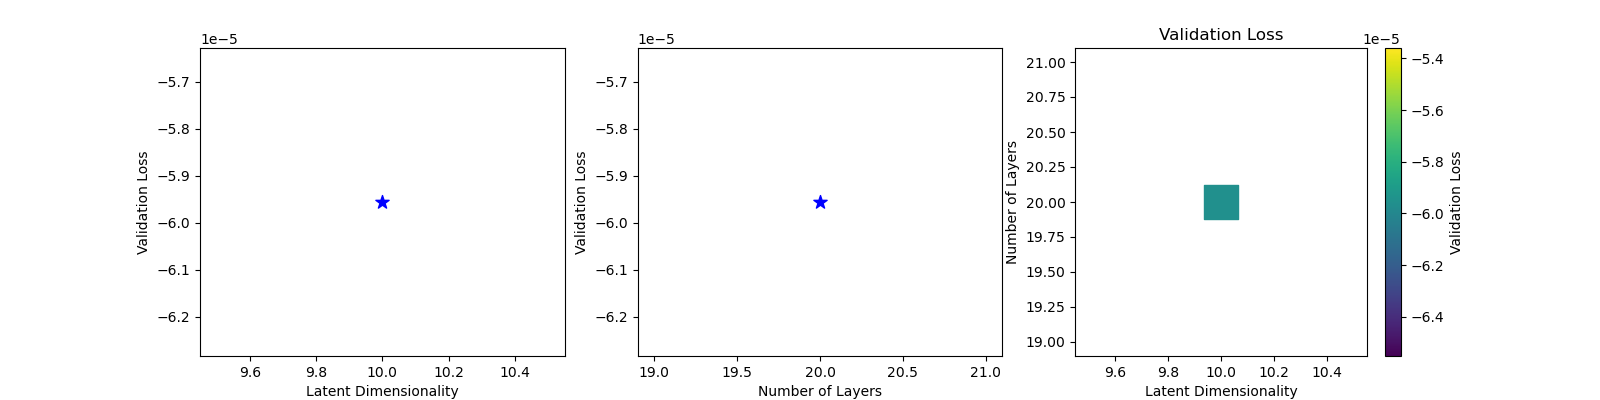

In [10]:
 #Compare loss as a function of latent dimensionality

latent_dims = [m["latent_dim"] for m in model_list]
nlayers = [m["nlayers"] for m in model_list]
val_scores = [m["result"]["val"][0]["test_loss"] for m in model_list]
colors = [m["color"] for m in model_list]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes[0].scatter(latent_dims, val_scores, color=colors, marker="*", s=100)
axes[0].set_xlabel("Latent Dimensionality")
axes[0].set_ylabel("Validation Loss")

axes[1].scatter(nlayers, val_scores, color=colors, marker="*", s=100)
axes[1].set_xlabel("Number of Layers")
axes[1].set_ylabel("Validation Loss")

# Scatter plot with latent_dim on x-axis, nlayers on y-axis, and colormap on z-axis (val_scores)
scatter = axes[2].scatter(latent_dims, nlayers, c=val_scores, cmap='viridis', marker="s", s=600)
axes[2].set_xlabel("Latent Dimensionality")
axes[2].set_ylabel("Number of Layers")
axes[2].set_title("Validation Loss")

# Add colorbar
cbar = fig.colorbar(scatter, ax=axes[2])
cbar.set_label("Validation Loss")
plt.show()

In [11]:
def plot(inTensor, axes, color, dim, label, linestyle="--"):
    for i, ax in enumerate(axes.flat):
        if i >= len(inTensor):
            break
        ax.plot(inTensor[i][0][dim].numpy(), linestyle, color=color, label=label)
        ax.legend()

def reconstruct_signals(input_signal, model_l, axes, dim):
    # Reconstruct images
    model = model_l["model"].eval()
    color = model_l["color"]
    label = "ld %s nl %s" % (model_l["latent_dim"], model_l["nlayers"])
    with torch.no_grad():
        reconst_imgs = model(input_signal.to(model.device))    
    reconst_imgs = reconst_imgs.cpu()
    plot(reconst_imgs, axes, color, dim, label)

def generate_signals(input_latents, model_l, axes, dim):
    # Reconstruct images
    model = model_l["model"].eval()
    color = model_l["color"]
    label = "ld %s nl %s" % (model_l["latent_dim"], model_l["nlayers"])
    with torch.no_grad():
        reconst_imgs = model.decoder(input_latents.to(model.device))    
    reconst_imgs = reconst_imgs.cpu()
    plot(reconst_imgs, axes, color, dim, label)

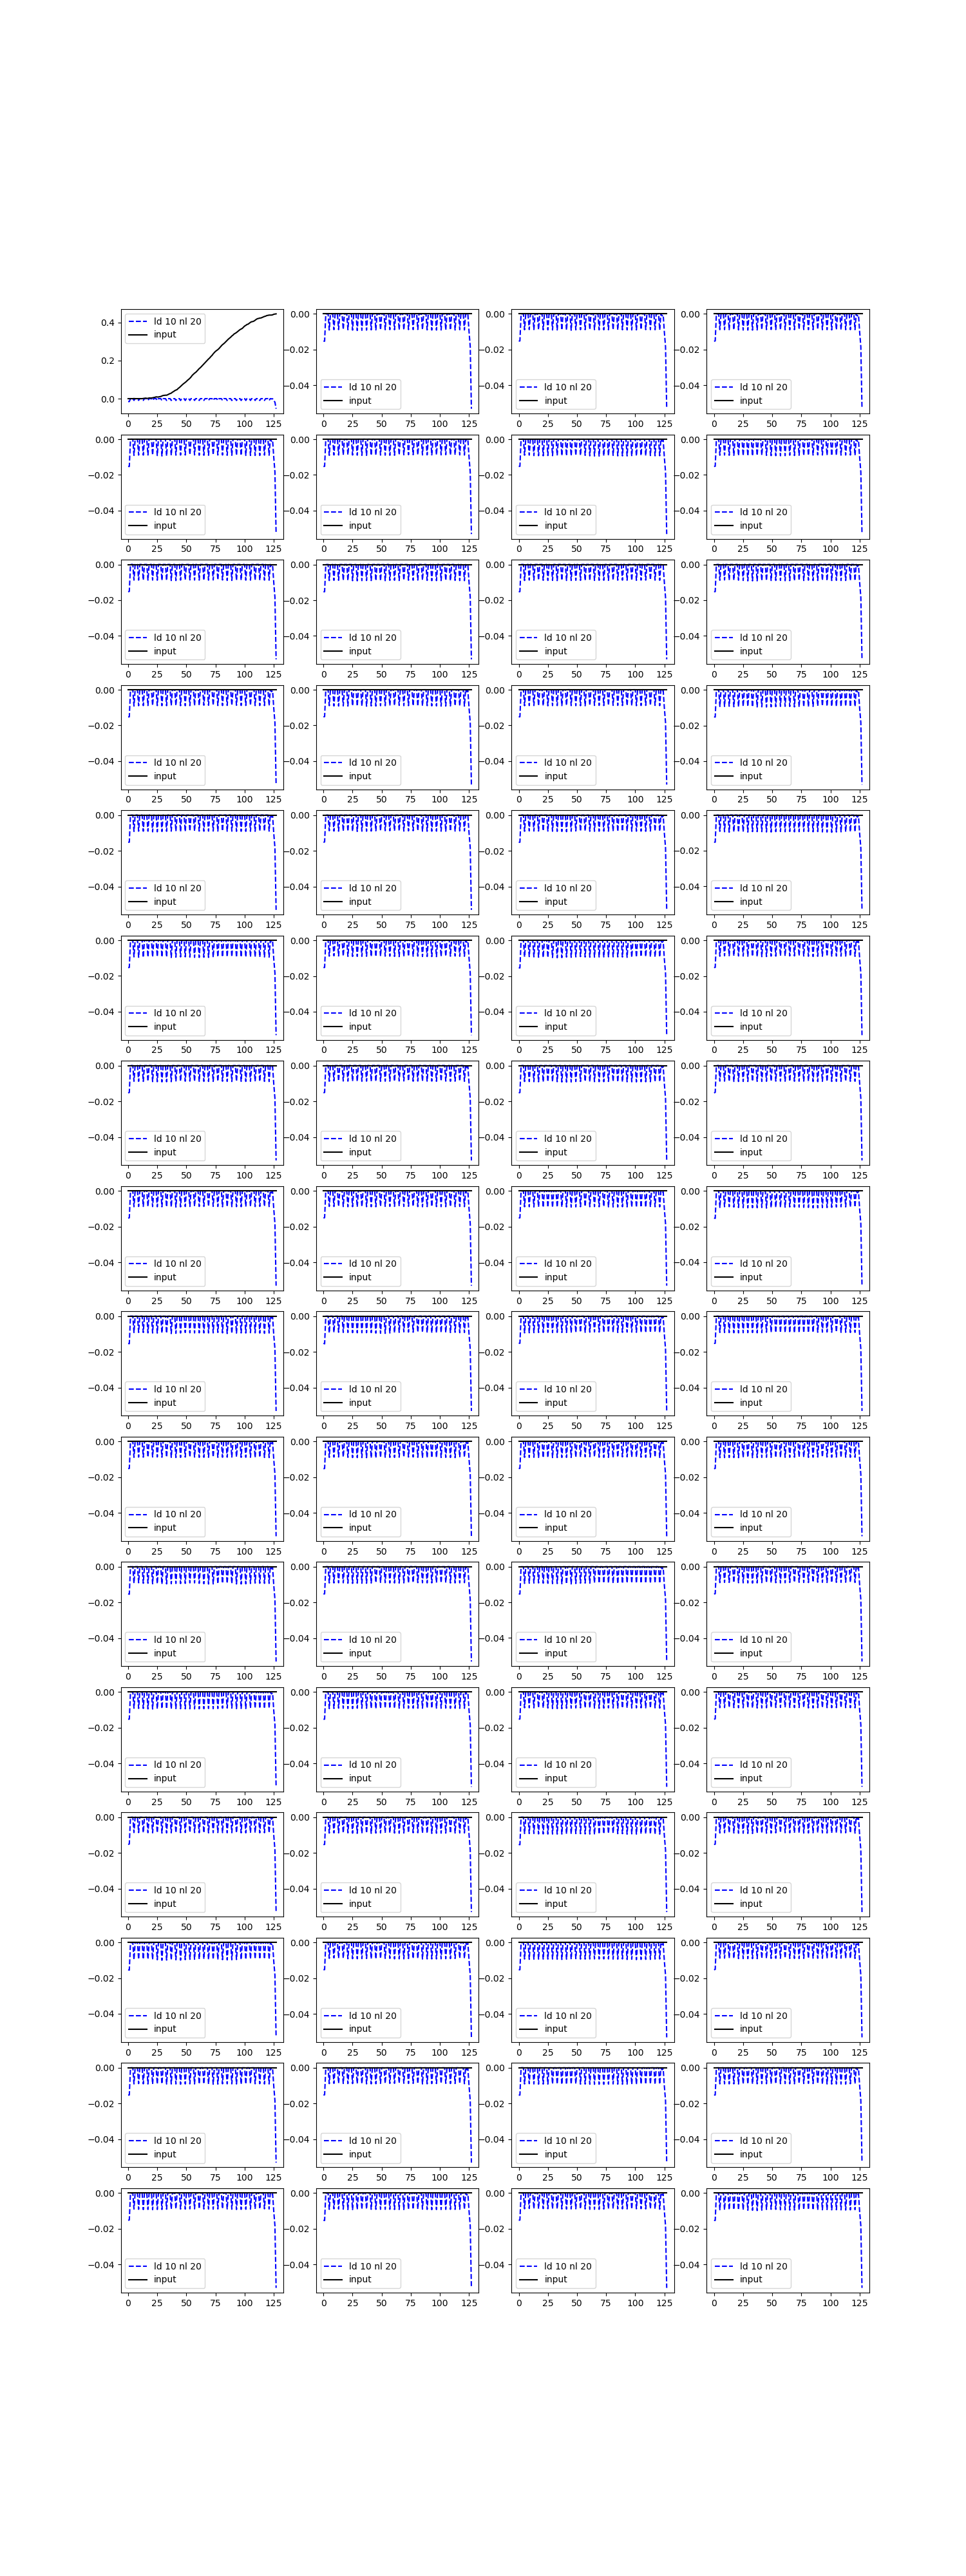

In [12]:
#Compare the reconstructions with different model hyper-parameters
ncols = 4
nrows = 16
dim = 0

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 40))
input_imgs = get_train_images(ncols*nrows)
#input_imgs = get_validation_images(ncols*nrows)

for m in model_list:
    reconstruct_signals(input_imgs, m, axes, dim)
plot(input_imgs, axes, "black", dim=dim, label="input", linestyle="-")

plt.show()

In [13]:
#Visualize the latent space

idx_test = 0
#model = model_list[idx_test]["model"]

latent_space_dict = {}
latent_space_dict["beam"] = {
    "values": np.array([    
                            #[1195, -1209],
                            #[119, -120],
                        ], dtype=np.float32),
    "color": "red"
} 
latent_space_dict["noise"] = {
    "values": np.array([    
                            #[1199, -1211],
                            #[119, -121],
                        ], dtype=np.float32),
    "color": "green"
} 
latent_space_dict["particle"] = {
    "values": np.array([    
                            #[1197, -1213.87],
                            #[119, -121],
                        ], dtype=np.float32),
    "color": "black"
} 

with torch.no_grad():
    model_list[idx_test]["model"].eval()
    histoOut = torch.histogramdd(   model_list[idx_test]["model"].encoder(get_train_images(1_000_000)),
                                    bins=5_000,
                                    #range = [-20, 5, -5, 15],
                                    range = None,
                                    )  # Define the range for each dimension)


if len(histoOut[0].size()) == 2:
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))
    axes.imshow(histoOut[0].detach().numpy(), 
                extent=[histoOut[1][0][0], 
                        histoOut[1][0][-1],
                        histoOut[1][1][0], 
                        histoOut[1][1][-1]], 
                aspect='auto', 
                origin='lower', 
                norm=matplotlib.colors.LogNorm())
elif len(histoOut[0].size()) == 3:
    histoproj = []
    histoproj.append(histoOut[0].sum(dim=0))
    histoproj.append(histoOut[0].sum(dim=1))
    histoproj.append(histoOut[0].sum(dim=2))
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i >= len(histoproj): break
        ax.imshow(histoproj[i].detach().numpy(), 
                  #extent=[histoOut[1][0][0], 
                  #        histoOut[1][0][-1],
                  #        histoOut[1][1][0], 
                  #        histoOut[1][1][-1]], 
                    aspect='auto', 
                    origin='lower', 
                    norm=matplotlib.colors.LogNorm())

plt.show()

for key, value in latent_space_dict.items():
    for x, y in value["values"]:
        axes.annotate("[%.2f, %.2f]" % (x, y), (x, y), color=value["color"], bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))
    axes.scatter(value["values"][:, 0], value["values"][:, 1], marker='x', color=value["color"], s=100)

#del outTensor
#plt.show()

RuntimeError: numel: integer multiplication overflow

: 

In [ ]:
#Generate new signals randomly (checking the latent space)
#signalType="beam"
#signalType="noise"
signalType="particle"
ncols = math.ceil(math.sqrt(latent_space_dict[signalType]["values"].shape[0]))
nrows = math.ceil(latent_space_dict[signalType]["values"].shape[0]/ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i>=latent_space_dict[signalType]["values"].shape[0]: break
    ax.set_title(' '.join(map(str, latent_space_dict[signalType]["values"][i])))

generate_signals(torch.from_numpy(latent_space_dict[signalType]["values"]), model_list[idx_test], axes, dim=0)

In [ ]:
#Finding similar signals in the latent space and then checking the signals

def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in data_loader:
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))


train_img_embeds = embed_imgs(model_list[idx_test]["model"], train_loader)
test_img_embeds = embed_imgs(model_list[idx_test]["model"], test_loader)

def find_similar_images(query_img, query_z, key_embeds, ax, K=8, dim=0):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    #grid = torchvision.utils.make_grid(imgs_to_display, nrow=K + 1, normalize=True, value_range=(-1, 1))
    #grid = grid.permute(1, 2, 0)
    #plt.figure(figsize=(12, 3))
    #plt.imshow(grid)
    #plt.axis("off")
    #plt.show()
    colors = ["b", "g", "r", "c", "m", "y", "k", "w", "orange", "purple", "brown", "pink"]
    ax.plot(query_img[0][dim].numpy(), color="k", label="query")
    for i in range(imgs_to_display.size()[0]):
        ax.plot(imgs_to_display[i][0][dim].numpy(), "--", color=colors.pop(0), label="latent_dim %i" % latent_dim)

In [ ]:
# Plot the closest images for the first N test images as example
ncols = 6
nrows = 6
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds, K=6, ax=ax, dim=0)

#This does not make sense, i probabily did something wrong